### This notebook is used to solve the regression probelm of our dataset. The problem statement focuses on predicting the 10 scale rating score using the rest of the attributes

### We will buliding traditional machine learning model as well as state of the art neural network

<h3>Student Name : Laxman Kumar <br> Subject Name : IST 736 Text Mining <br> University : Syracuse University <br> Professor : Prof Yingya Li</h3>

#### Resouces used are https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018

# Building Traditional Machine Learning model

In [1]:
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt

import re
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB,BernoulliNB
from sklearn.svm import LinearSVC,SVC,SVR
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from time import time

import nltk
%matplotlib inline

## Loading the cleaned data

In [3]:
df = pd.read_csv("cleaned.csv")

## Splitting the data into train, test and validation

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df['review'], df['rating'], test_size=0.2, random_state=0)

In [5]:
#X_train, X_tdsdest, y_train, y_tesdsst = train_test_split(df['review'], df['rating'], test_size=0.8, random_state=0)

## Initialising the vectorizer.

In [6]:
stop_words = set(stopwords.words('english'))

In [7]:
countVectorizer = CountVectorizer(binary=False, min_df = 20, stop_words = stop_words, analyzer = 'word',ngram_range=(1,2))
countVector_train = countVectorizer.fit_transform(X_train)
countVector_val = countVectorizer.transform(X_test)

In [8]:
tfidfVectorizer = TfidfVectorizer(min_df = 20, stop_words = stop_words, analyzer = 'word',ngram_range=(1,2))
tfidfVector_train = tfidfVectorizer.fit_transform(X_train)
tfidfVector_train = tfidfVectorizer.transform(X_test)

## Building and comparing different models

### Customized function for calculating the accuracy of a model

In [ ]:
def accuracy_summary(pipeline, x_train, y_train, x_test, y_test):
    if len(x_test[y_test == 0]) / (len(x_test)*1.) > 0.5:
        null_accuracy = len(x_test[y_test == 0]) / (len(x_test)*1.)
    else:
        null_accuracy = 1. - (len(x_test[y_test == 0]) / (len(x_test)*1.))
    t0 = time()
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    print("null accuracy: {0:.2f}%".format(null_accuracy*100))
    print("accuracy score: {0:.2f}%".format(accuracy*100))
    if accuracy > null_accuracy:
        print("model is {0:.2f}% more accurate than null accuracy".format((accuracy-null_accuracy)*100))
    elif accuracy == null_accuracy:
        print("model has the same accuracy with the null accuracy")
    else:
        print("model is {0:.2f}% less accurate than null accuracy".format((null_accuracy-accuracy)*100))
    print("train and test time: {0:.2f}s".format(train_test_time))
    print("-"*80)
    return accuracy, train_test_time

### Generating report for three models with their default hyperparameters

In [ ]:
names = ["Linear SVC", "Multinomial NB", "Bernoulli NB"]
classifiers = [LinearSVC(),MultinomialNB(),BernoulliNB()]

zipped_clf = zip(names,classifiers)

tvec = TfidfVectorizer()
tvec1 = CountVectorizer()
def classifier_comparator(vectorizer=tvec1,  stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([('vectorizer', vectorizer),('classifier', c)])
        print("Validation result for {}".format(n))
        clf_accuracy,tt_time = accuracy_summary(checker_pipeline, X_train, y_train, X_test, y_test)
        result.append((n,clf_accuracy,tt_time))
    return result

#trigram_result = classifier_comparator(ngram_range=(1,1))
#trigram_result = classifier_comparator(ngram_range=(1,2))
trigram_result = classifier_comparator(ngram_range=(1,3))

After running several combination of vectorizer and ngram range Count vectorizer with ngram range of 1-3 gives the best result.

### Running the best model with different combination of hyperparameters

In [24]:
countVectorizer = CountVectorizer(binary=False,  stop_words = stop_words, analyzer = 'word',ngram_range=(1,3))
countVector_train = countVectorizer.fit_transform(X_train)
countVector_val = countVectorizer.transform(X_test)

In [27]:
nb = LinearSVC(C=1.5,max_iter=1500)
nb.fit(countVector_train, y_train)
y_pred_class = nb.predict(countVector_val)
from sklearn import metrics
metrics.accuracy_score(y_test, y_pred_class)

0.6702399344200272

In [21]:
LinearSVC()

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)

# Bulding a Neural Network

In [28]:
import numpy as np

In [29]:
import keras 
from keras.models import Sequential, Model 
from keras import layers
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, Input, Embedding
from keras.layers.merge import Concatenate
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud
from keras.utils.np_utils import to_categorical 
from nltk.tokenize import RegexpTokenizer
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, confusion_matrix, recall_score

Using TensorFlow backend.


## Splitting the data into train, test and validation

In [30]:
x_train, x_valid, y_train, y_valid = train_test_split(df['review'], df['rating'], test_size=0.2, random_state=42)
x_test, x_valid, y_test, y_valid = train_test_split(x_valid, y_valid, test_size=0.5, random_state=42)

## Preparing data for neural network

In [31]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
vectorizer = TfidfVectorizer(ngram_range=(1,2))

x_train_vectors = vectorizer.fit_transform(x_train)
x_valid_vectors = vectorizer.transform(x_valid)
x_test_vectors = vectorizer.transform(x_test)

selector = SelectKBest(f_classif, k=min(1000, x_train_vectors.shape[1]))
selector.fit(x_train_vectors, y_train)

x_train_vectors = selector.transform(x_train_vectors).astype('float32')
x_valid_vectors = selector.transform(x_valid_vectors).astype('float32')
x_test_vectors = selector.transform(x_test_vectors).astype('float32')

new_x_train = np.array(x_train_vectors)
new_x_valid = np.array(x_train_vectors)

In [32]:
y_train_one_hot = to_categorical(y_train)
y_valid_one_hot = to_categorical(y_valid)

## Building the neural network model

In [68]:
model_mlp3 = keras.models.Sequential()

model_mlp3.add(keras.layers.Dense(1024, input_shape=(1000,)))
model_mlp3.add(keras.layers.Activation('relu'))

model_mlp3.add(keras.layers.Dense(512))
model_mlp3.add(keras.layers.Activation('relu'))

model_mlp3.add(keras.layers.Dense(256, activation='relu'))
model_mlp3.add(keras.layers.Dense(11, activation='sigmoid'))

model_mlp3.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_mlp3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 1024)              1025024   
_________________________________________________________________
activation_7 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               524800    
_________________________________________________________________
activation_8 (Activation)    (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_16 (Dense)             (None, 11)                2827      
Total params: 1,683,979
Trainable params: 1,683,979
Non-trainable params: 0
____________________________________________

### Training the neural net using train set and validation set

In [ ]:
history3 = model_mlp3.fit(x_train_vectors, y_train_one_hot, epochs=25, batch_size=64, validation_data=(x_valid_vectors, y_valid_one_hot))

Train on 126867 samples, validate on 15859 samples
Epoch 1/25
105536/126867 [=======================>......] - ETA: 21s - loss: 1.6353 - accuracy: 0.4168

### Ploting the accuracy and loss

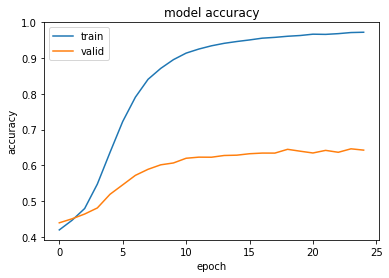

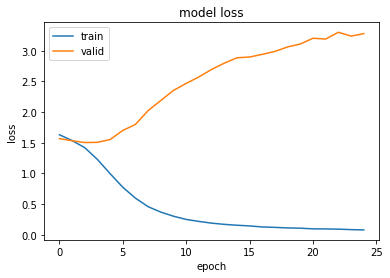

In [63]:
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

### Displaying the evaluation metrics

In [64]:
y_pred2_3 = model_mlp3.predict_classes(x_test_vectors)
classification_report(y_test, y_pred2_3, target_names=["class 1", "class 2", "class 3", "class 4", "class 5", 
                                                        "class 6","class 7","class 8","class 9","class 10"])

'              precision    recall  f1-score   support\n\n     class 1       0.73      0.77      0.75      2101\n     class 2       0.61      0.53      0.57       661\n     class 3       0.60      0.51      0.55       685\n     class 4       0.55      0.49      0.52       487\n     class 5       0.61      0.50      0.55       790\n     class 6       0.65      0.48      0.55       646\n     class 7       0.46      0.56      0.51       906\n     class 8       0.60      0.56      0.58      1866\n     class 9       0.56      0.64      0.60      2686\n    class 10       0.76      0.75      0.75      5030\n\n    accuracy                           0.65     15858\n   macro avg       0.61      0.58      0.59     15858\nweighted avg       0.65      0.65      0.65     15858\n'

In [65]:
print("Precision Score ",precision_score(y_test, y_pred2_3, average='macro'))
print("Recall ",recall_score(y_test, y_pred2_3, average='macro'))
print('Accuracy = {}'.format(np.sum(y_pred2_3 == y_test) / len(y_test)))

Precision Score  0.611618860637237
Recall  0.5783199674841328
Accuracy = 0.648757724807668


### Customized function for building a confusion matrix

In [66]:
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Confusion Metrics

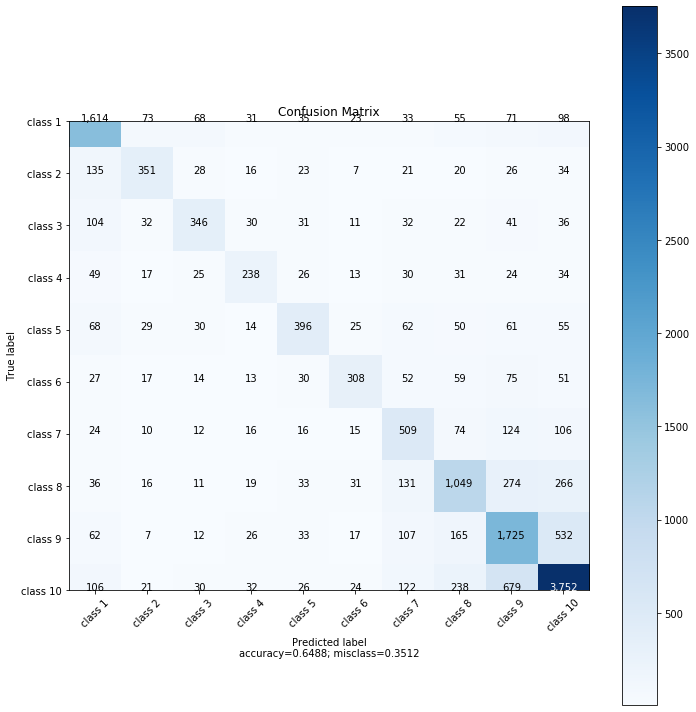

In [67]:
cm2_3 = confusion_matrix(y_pred=y_pred2_3, y_true=y_test)

plot_confusion_matrix(cm           = cm2_3, 
                      normalize    = False,
                      target_names = ["class 1", "class 2", "class 3", "class 4", "class 5", 
                                                        "class 6","class 7","class 8","class 9","class 10"],
                      title        = "Confusion Matrix")